In [1]:
import os
import time
import tejapi
import talib as ta
from talib import abstract
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from datetime import datetime
from datetime import timedelta
import configparser
import re
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.schedules import ExponentialDecay
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler

In [2]:
from initialize import ML_stock
from select_1 import sample, column, feature

In [3]:
from tensorflow.keras.models import load_model

# 載入模型
model = load_model(f'lstm_{sample[1]}.keras')

In [4]:
ml_stock = ML_stock()
ml_stock.ini()
start = '2021-01-01'
end = '2024-06-30'

In [5]:
os.environ['mdate'] = start + ' ' + end
os.environ['ticker'] = ' '.join([sample[1]]) + ' ' + 'IR0001'
!zipline ingest -b tquant

[2024-07-26 07:59:19.665952] INFO: zipline.data.bundles.core: Ingesting tquant.
Merging daily equity files:  [####################################]   
Currently used TEJ API key call quota 566/9223372036854775807 (0.0%)
Currently used TEJ API key data quota 5605573/9223372036854775807 (0.0%)
[2024-07-26 07:59:21.083967] INFO: zipline.data.bundles.core: Ingest tquant successfully.


In [6]:
df = ml_stock.get_fundamental(start, end, [sample[1]], column)
df = ml_stock.calculate_all_technical_indicators(df)
preporc_data = ml_stock.preprocessing(df)

/Users/chencongyao/anaconda3/envs/tq/lib/python3.11/site-packages/dask/dataframe/__init__.py:49: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


Currently used TEJ API key call quota 574/9223372036854775807 (0.0%)
Currently used TEJ API key data quota 5611739/9223372036854775807 (0.0%)


In [7]:
data = preporc_data.drop(columns=['mdate', 'coid'])
data

,volume,low,close,open,high,Return_Rate_on_Equity_A_percent_Q,MOM,RSI
0,51954.0,12.80,13.05,13.15,13.20,-2.38,0.00,0.000000
1,24103.0,12.80,12.95,13.05,13.05,-2.38,0.00,0.000000
2,23433.0,12.90,12.95,13.00,13.15,-2.38,0.00,0.000000
3,28689.0,12.70,12.70,12.95,13.05,-2.38,0.00,0.000000
4,18311.0,12.65,12.90,12.70,12.95,-2.38,0.00,0.000000
...,...,...,...,...,...,...,...,...
841,79873.0,37.30,37.75,38.10,38.25,4.55,0.85,61.936425
842,51978.0,37.10,37.75,37.75,37.75,4.55,1.05,61.936425
843,58029.0,37.55,37.85,37.90,38.15,4.55,1.00,62.673481
844,167554.0,37.70,38.90,37.85,39.10,4.55,2.65,69.378392


In [8]:
def create_dataset(df, window_size=5):
    df = data
    features = df[feature].values
    
    target = df['close'].shift(-1).values  # y變量為隔日收盤價
    target[-1] = target[-2]

    scaler = StandardScaler()
    features = scaler.fit_transform(features)
    t_scaler = StandardScaler()
    target = t_scaler.fit_transform(target.reshape(-1, 1))

    X, y = [], []
    for i in range(len(df) - window_size):
        X.append(features[i:i + window_size])
        y.append(target[i + window_size])

    return np.array(X), np.array(y), t_scaler

In [9]:
X, y, t_scaler = create_dataset(data, 5)

In [10]:
prediction = model.predict(X)

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [11]:
dates = preporc_data.loc[5:, 'mdate'].values
prediction_unscaled = t_scaler.inverse_transform(prediction.reshape(-1, 1))
y_unscaled = t_scaler.inverse_transform(y.reshape(-1, 1))

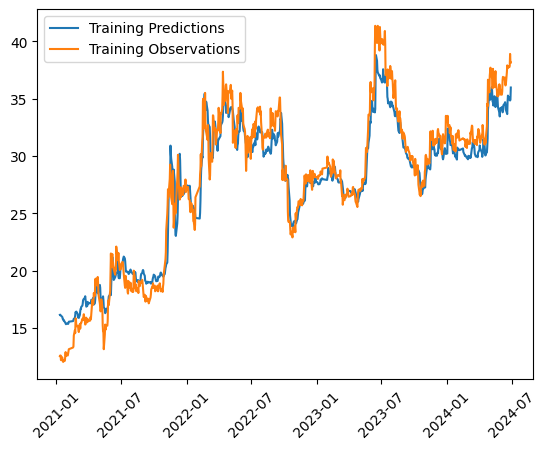

In [12]:
plt.plot(dates, prediction_unscaled)
plt.plot(dates, y_unscaled)
plt.legend(['Training Predictions', 'Training Observations'])
plt.xticks(rotation = 45)
plt.show()

In [13]:
pipline_data =  pd.DataFrame({
    'mdate': dates,
    'coid': '2618',
    'pred': prediction_unscaled.reshape(-1)
})
pipline_data

,mdate,coid,pred
0,2021-01-11,2618,16.148129
1,2021-01-12,2618,16.161499
2,2021-01-13,2618,16.102386
3,2021-01-14,2618,16.071468
4,2021-01-15,2618,16.054342
...,...,...,...
836,2024-06-24,2618,35.108486
837,2024-06-25,2618,35.040936
838,2024-06-26,2618,34.836926
839,2024-06-27,2618,34.925930


In [14]:
from zipline.data import bundles

bundle_name = 'tquant'
bundle = bundles.load(bundle_name)

In [15]:
from zipline.pipeline.data.dataset import Column, DataSet
from zipline.pipeline.domain import TW_EQUITIES

class CustomDataset(DataSet):
    
    pred = Column(float)

    domain = TW_EQUITIES

In [16]:
sids = bundle.asset_finder.equities_sids
assets = bundle.asset_finder.retrieve_all(sids)
symbol_mapping_sid = {i.symbol:i.sid for i in assets}

In [17]:
transform_data = pipline_data.set_index(['coid', 'mdate']).unstack('coid')
transform_data = transform_data.rename(columns = symbol_mapping_sid)
transform_data.index = transform_data.index.tz_localize('UTC')
transform_data

,pred
coid,0
mdate,
2021-01-11 00:00:00+00:00,16.148129
2021-01-12 00:00:00+00:00,16.161499
2021-01-13 00:00:00+00:00,16.102386
2021-01-14 00:00:00+00:00,16.071468
2021-01-15 00:00:00+00:00,16.054342
...,...
2024-06-24 00:00:00+00:00,35.108486
2024-06-25 00:00:00+00:00,35.040936


In [18]:
from zipline.pipeline.loaders.frame import DataFrameLoader

custom_loader = {}

inputs=[
        CustomDataset.pred
        ]

for i in inputs:
    custom_loader[i]=DataFrameLoader(column=i,
                                     baseline=transform_data[i.name])
custom_loader

{CustomDataset<TW>.pred::float64: <zipline.pipeline.loaders.frame.DataFrameLoader at 0x3101524d0>}

In [19]:
from zipline.pipeline import SimplePipelineEngine
from zipline.pipeline.data import TWEquityPricing
from zipline.pipeline.loaders import EquityPricingLoader

pricing_loader = EquityPricingLoader.without_fx(bundle.equity_daily_bar_reader,
                                                bundle.adjustment_reader)
def choose_loader(column):
    if column.name in TWEquityPricing._column_names:
        return pricing_loader
    elif column.name in CustomDataset._column_names:     
        return custom_loader[column]
    else:
        raise Exception('Column not available')
    
engine = SimplePipelineEngine(get_loader = choose_loader,
                              asset_finder = bundle.asset_finder,
                              default_domain = TW_EQUITIES)

In [20]:
pd.reset_option('display.max_columns')
pd.reset_option('display.max_rows')

In [21]:
from zipline.pipeline.factors import TrueRange, CustomFactor
from zipline.pipeline.factors import CustomFactor
from zipline.utils.math_utils import nanmax
from numpy import dstack

class Return(CustomFactor):
    inputs = [CustomDataset.pred]
    window_length = 2

    def compute(self, today, assets, out, pred):

        returns = (pred[1]/pred[0] - 1).round(3)
        out[:] = returns

class AverageTrueRange(CustomFactor):

    inputs = (
        TWEquityPricing.high,
        TWEquityPricing.low,
        TWEquityPricing.close,
    )

    window_length = 10

    outputs = ["TR", "ATR"]

    def compute(self, today, assets, out, highs, lows, closes):

        high_to_low = highs[1:] - lows[1:]
        high_to_prev_close = abs(highs[1:] - closes[:-1])
        low_to_prev_close = abs(lows[1:] - closes[:-1])
        tr_current = nanmax(
            dstack(
                (
                    high_to_low,
                    high_to_prev_close,
                    low_to_prev_close,
                )
            ),
            2,
        )

        sma_atr_values = np.mean(tr_current, axis=0)

        out.TR = tr_current[-1]
        out.ATR = sma_atr_values

In [22]:
from zipline.pipeline import Pipeline
from zipline.pipeline.filters import StaticAssets
benchmark_asset = bundle.asset_finder.lookup_symbol('IR0001',as_of_date = None)

def make_pipeline():
    pred = CustomDataset.pred.latest
    price = TWEquityPricing.close.latest
    returns = Return(inputs=[TWEquityPricing.close])
    returns_pred = Return()
    ATR = AverageTrueRange(inputs = [TWEquityPricing.high,
                                 TWEquityPricing.low,
                                TWEquityPricing.close]) 

    return Pipeline(
        columns = {
            'price': price,
            'pred': pred,
            'return': returns,
            'return_pred': returns_pred,
            'atr': ATR.ATR,
                },
            screen = ~StaticAssets([benchmark_asset])
    )

start = '2021-01-01'
end = '2024-06-30'
start_dt = pd.Timestamp(start, tz = 'UTC')
end_dt = pd.Timestamp(end, tz = 'UTC')
        
pipeline_result = engine.run_pipeline(make_pipeline(), start_dt, end_dt)
pipeline_result

,,price,pred,return,return_pred,atr
2021-01-05 00:00:00+00:00,Equity(0 [2618]),13.05,NaN,NaN,NaN,NaN
2021-01-06 00:00:00+00:00,Equity(0 [2618]),12.95,NaN,-0.008,NaN,NaN
2021-01-07 00:00:00+00:00,Equity(0 [2618]),12.95,NaN,0.000,NaN,NaN
2021-01-08 00:00:00+00:00,Equity(0 [2618]),12.70,NaN,-0.019,NaN,NaN
2021-01-11 00:00:00+00:00,Equity(0 [2618]),12.90,16.148129,0.016,NaN,NaN
...,...,...,...,...,...,...
2024-06-24 00:00:00+00:00,Equity(0 [2618]),37.85,35.108486,0.005,0.005,0.800000
2024-06-25 00:00:00+00:00,Equity(0 [2618]),37.75,35.040936,-0.003,-0.002,0.811111
2024-06-26 00:00:00+00:00,Equity(0 [2618]),37.75,34.836926,0.000,-0.006,0.794444
2024-06-27 00:00:00+00:00,Equity(0 [2618]),37.85,34.925930,0.003,0.003,0.794444


In [23]:
from zipline.finance import slippage, commission
from zipline.api import *

def initialize(context):
    set_slippage(slippage.VolumeShareSlippage())
    set_commission(commission.Custom_TW_Commission(min_trade_cost = 20, discount = 1.0, tax = 0.003))
    set_benchmark(symbol('IR0001'))
    attach_pipeline(make_pipeline(), 'mystrats')
    context.stop_loss = 0
    context.last_price = 0

In [24]:
def handle_data(context, data):
    out_dir = pipeline_output('mystrats')

    for i in out_dir.index:
        sym = i.symbol
        buy, sell = False, False
        price = out_dir.loc[i, 'price']
        pred = out_dir.loc[i, 'pred']
        returns = out_dir.loc[i, 'return']
        return_pred = out_dir.loc[i, 'return_pred']
        atr = out_dir.loc[i, 'atr']

        cash_position = context.portfolio.cash
        stock_position = context.portfolio.positions[i].amount

        record(
           **{
                f'price_{sym}':price,
                f'buy_{sym}':buy,
                f'sell_{sym}':sell,
                f'pred_{sym}': pred
            }
        )

        if return_pred < 0 and cash_position >= 0 and returns < 0:
            order_percent(i , 0.48)
            buy = True
            record(
                **{
                    f'buy_{sym}':buy
                }
            )
            context.stop_loss = price - atr * 1.25

        if price > context.last_price + atr * 1.25 and context.last_price != 0:
            context.stop_loss = price - atr * 1.25
        
        elif stock_position > 0  and return_pred < -0.025:
            order_target_percent(i, 0)
            sell = True
            record(
                **{
                    f'sell_{sym}':sell
                }
            )
        elif price <= context.stop_loss and stock_position > 0:
            order_target(i, 0)
            sell = True
            record(
                **{
                    f'sell_{sym}':sell
                }
            )
        context.last_price = price

In [25]:
def analyze(context, results):
    plt.style.use('ggplot')

    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(16, 12))

    results['benchmark_cum'] = results.benchmark_return.add(1).cumprod()
    results['portfolio_returns'] = results.returns.add(1).cumprod()
    results['stock_price'] = results['price_2618'].add(1)


    results[['portfolio_returns', 'benchmark_cum']].plot(ax=ax1, label='Portfolio Value($)')
    results['stock_price'].plot(ax=ax2, label='Stock Price($)')
    results['pred_2618'].plot(ax=ax2, label='Pred')
    results[['ending_cash']].plot(ax=ax3, label='Portfolio Cash($)')

    buy_signals = results.buy_2618.fillna(False).astype(bool)
    sell_signals = results.sell_2618.fillna(False).astype(bool)

    ax2.plot( # Buy Signal
        results.index[buy_signals],
        results.loc[buy_signals, 'price_2618'],
        '^',
        markersize=5,
        color='red'
    )
    ax2.plot( # Sell Signal
        results.index[sell_signals],
        results.loc[sell_signals, 'price_2618'],
        'v',
        markersize=5,
        color='green'
    )

    plt.legend(loc='best')

    plt.show()

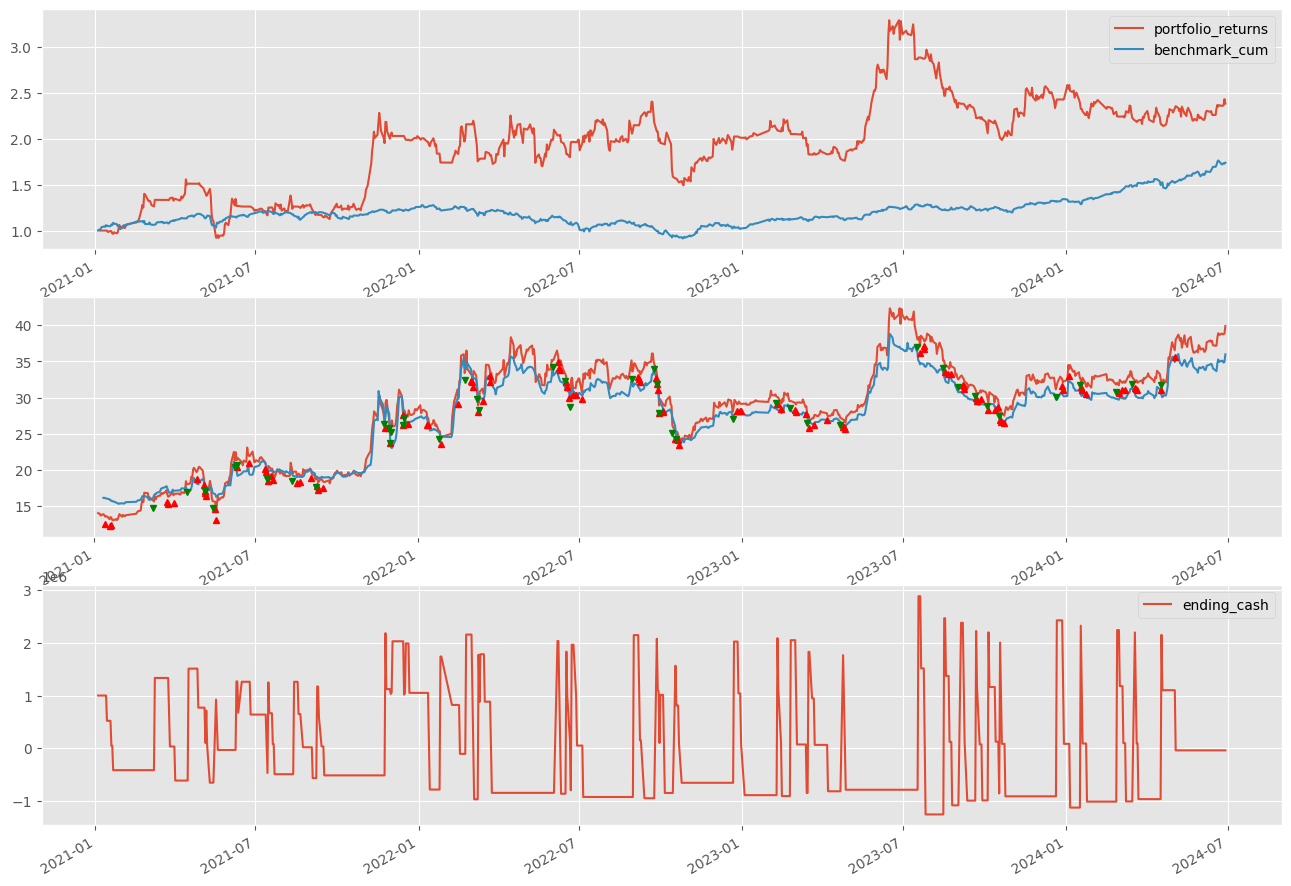

,period_open,period_close,pnl,starting_exposure,short_value,treasury_return,starting_value,net_leverage,positions,ending_value,...,max_drawdown,alpha,beta,price_2618,buy_2618,sell_2618,pred_2618,benchmark_cum,portfolio_returns,stock_price
2021-01-04 13:30:00+08:00,2021-01-04 09:01:00+08:00,2021-01-04 13:30:00+08:00,0.0,0.0,0.0,0.0,0.0,0.000000,[],0.0,...,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN
2021-01-05 13:30:00+08:00,2021-01-05 09:01:00+08:00,2021-01-05 13:30:00+08:00,0.0,0.0,0.0,0.0,0.0,0.000000,[],0.0,...,0.00000,NaN,NaN,13.05,False,False,NaN,1.006576,1.000000,14.05
2021-01-06 13:30:00+08:00,2021-01-06 09:01:00+08:00,2021-01-06 13:30:00+08:00,0.0,0.0,0.0,0.0,0.0,0.000000,[],0.0,...,0.00000,0.000000,0.000000,12.95,False,False,NaN,1.005442,1.000000,13.95
2021-01-07 13:30:00+08:00,2021-01-07 09:01:00+08:00,2021-01-07 13:30:00+08:00,0.0,0.0,0.0,0.0,0.0,0.000000,[],0.0,...,0.00000,0.000000,0.000000,12.95,False,False,NaN,1.020935,1.000000,13.95
2021-01-08 13:30:00+08:00,2021-01-08 09:01:00+08:00,2021-01-08 13:30:00+08:00,0.0,0.0,0.0,0.0,0.0,0.000000,[],0.0,...,0.00000,0.000000,0.000000,12.70,False,False,NaN,1.037708,1.000000,13.70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-24 13:30:00+08:00,2024-06-24 09:01:00+08:00,2024-06-24 13:30:00+08:00,-6364.4,2408925.4,0.0,0.0,2408925.4,1.017844,"[{'sid': Equity(0 [2618]), 'amount': 63644, 'c...",2402561.0,...,-0.40914,0.215940,1.025196,37.85,False,False,35.108486,1.720834,2.360441,38.85
2024-06-25 13:30:00+08:00,2024-06-25 09:01:00+08:00,2024-06-25 13:30:00+08:00,0.0,2402561.0,0.0,0.0,2402561.0,1.017844,"[{'sid': Equity(0 [2618]), 'amount': 63644, 'c...",2402561.0,...,-0.40914,0.214589,1.025107,37.75,False,False,35.040936,1.725860,2.360441,38.75
2024-06-26 13:30:00+08:00,2024-06-26 09:01:00+08:00,2024-06-26 13:30:00+08:00,6364.4,2402561.0,0.0,0.0,2402561.0,1.017796,"[{'sid': Equity(0 [2618]), 'amount': 63644, 'c...",2408925.4,...,-0.40914,0.213473,1.024964,37.75,False,False,34.836926,1.734421,2.366805,38.75
2024-06-27 13:30:00+08:00,2024-06-27 09:01:00+08:00,2024-06-27 13:30:00+08:00,66826.2,2408925.4,0.0,0.0,2408925.4,1.017308,"[{'sid': Equity(0 [2618]), 'amount': 63644, 'c...",2475751.6,...,-0.40914,0.224643,1.023920,37.85,False,False,34.925930,1.729984,2.433631,38.85


In [26]:
from zipline import run_algorithm

start = '2021-01-01'
end = '2024-06-28'
start_dt = pd.Timestamp(start, tz = 'UTC')
end_dt = pd.Timestamp(end, tz = 'UTC')

results = run_algorithm(
    start = start_dt,
    end = end_dt,
    initialize = initialize,
    bundle = 'tquant',
    analyze = analyze,
    capital_base = 1e6,
    handle_data = handle_data,
    custom_loader=custom_loader
)
results

In [27]:
import pyfolio as pf
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(results)

Start date,2021-01-04
End date,2024-06-28
Total months,40
,Backtest
Annual return,29.566%
Cumulative returns,138.59%
Annual volatility,48.86%
Sharpe ratio,0.77
Calmar ratio,0.72
Stability,0.65
Max drawdown,-40.914%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,40.91,2021-04-13,2021-05-20,2021-11-08,145
1,39.67,2023-06-26,2023-10-20,NaT,NaN
2,37.92,2022-09-21,2022-10-26,2023-05-29,163
3,25.49,2021-11-17,2022-05-20,2022-09-12,200
4,9.84,2021-02-25,2021-03-08,2021-04-12,30


Top 10 long positions of all time,max
sid,
2618,159.45%


Top 10 short positions of all time,max
sid,


Top 10 positions of all time,max
sid,
2618,159.45%


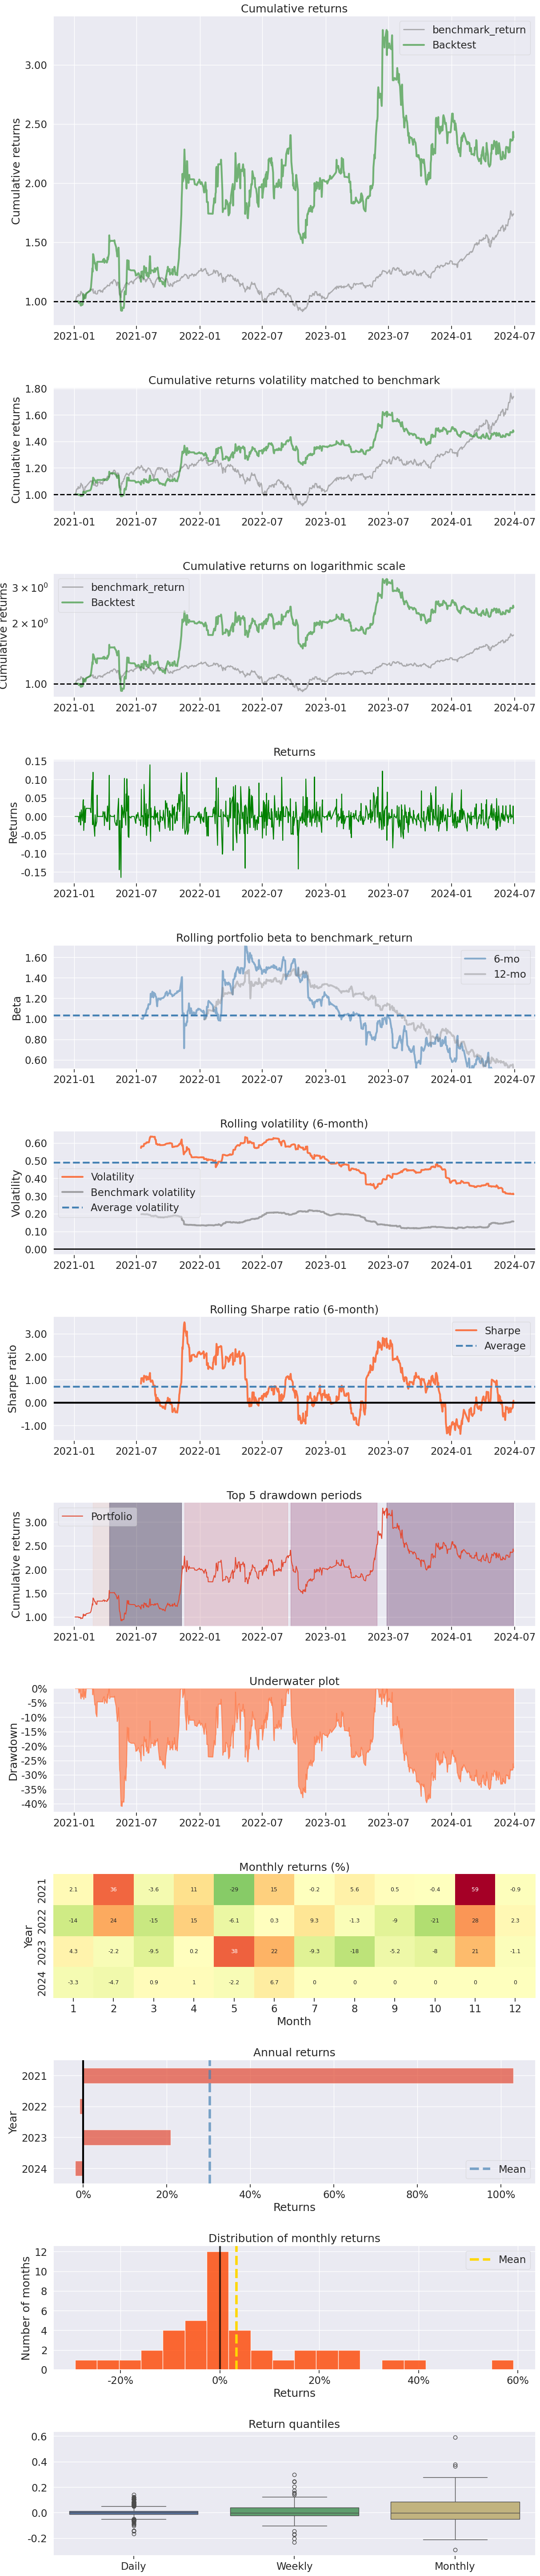

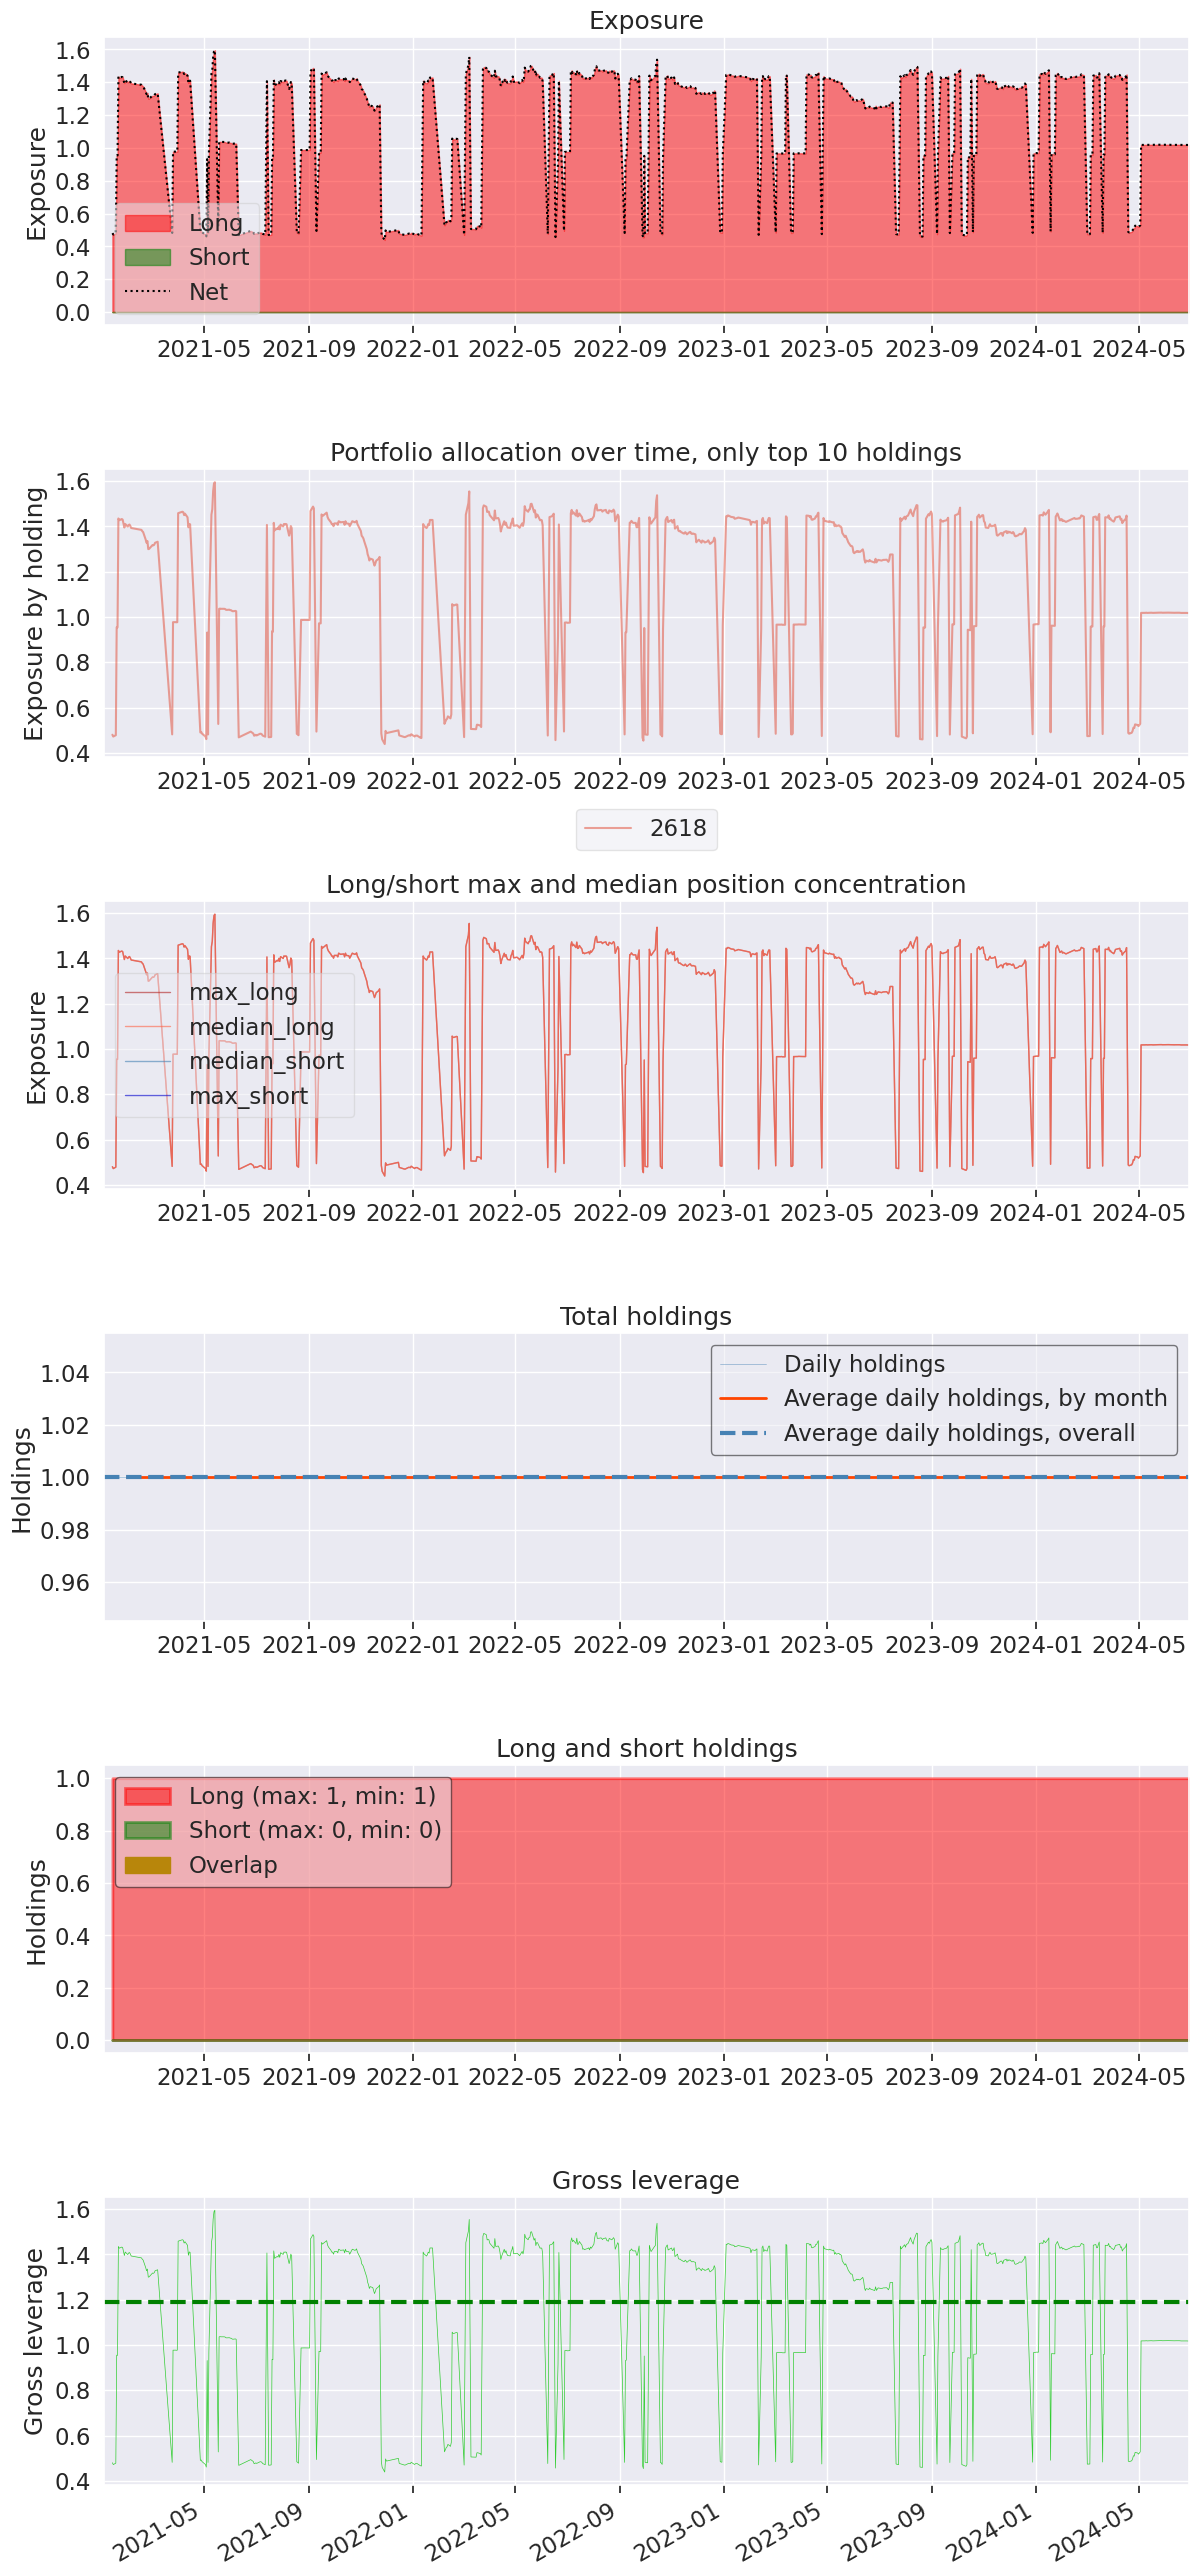

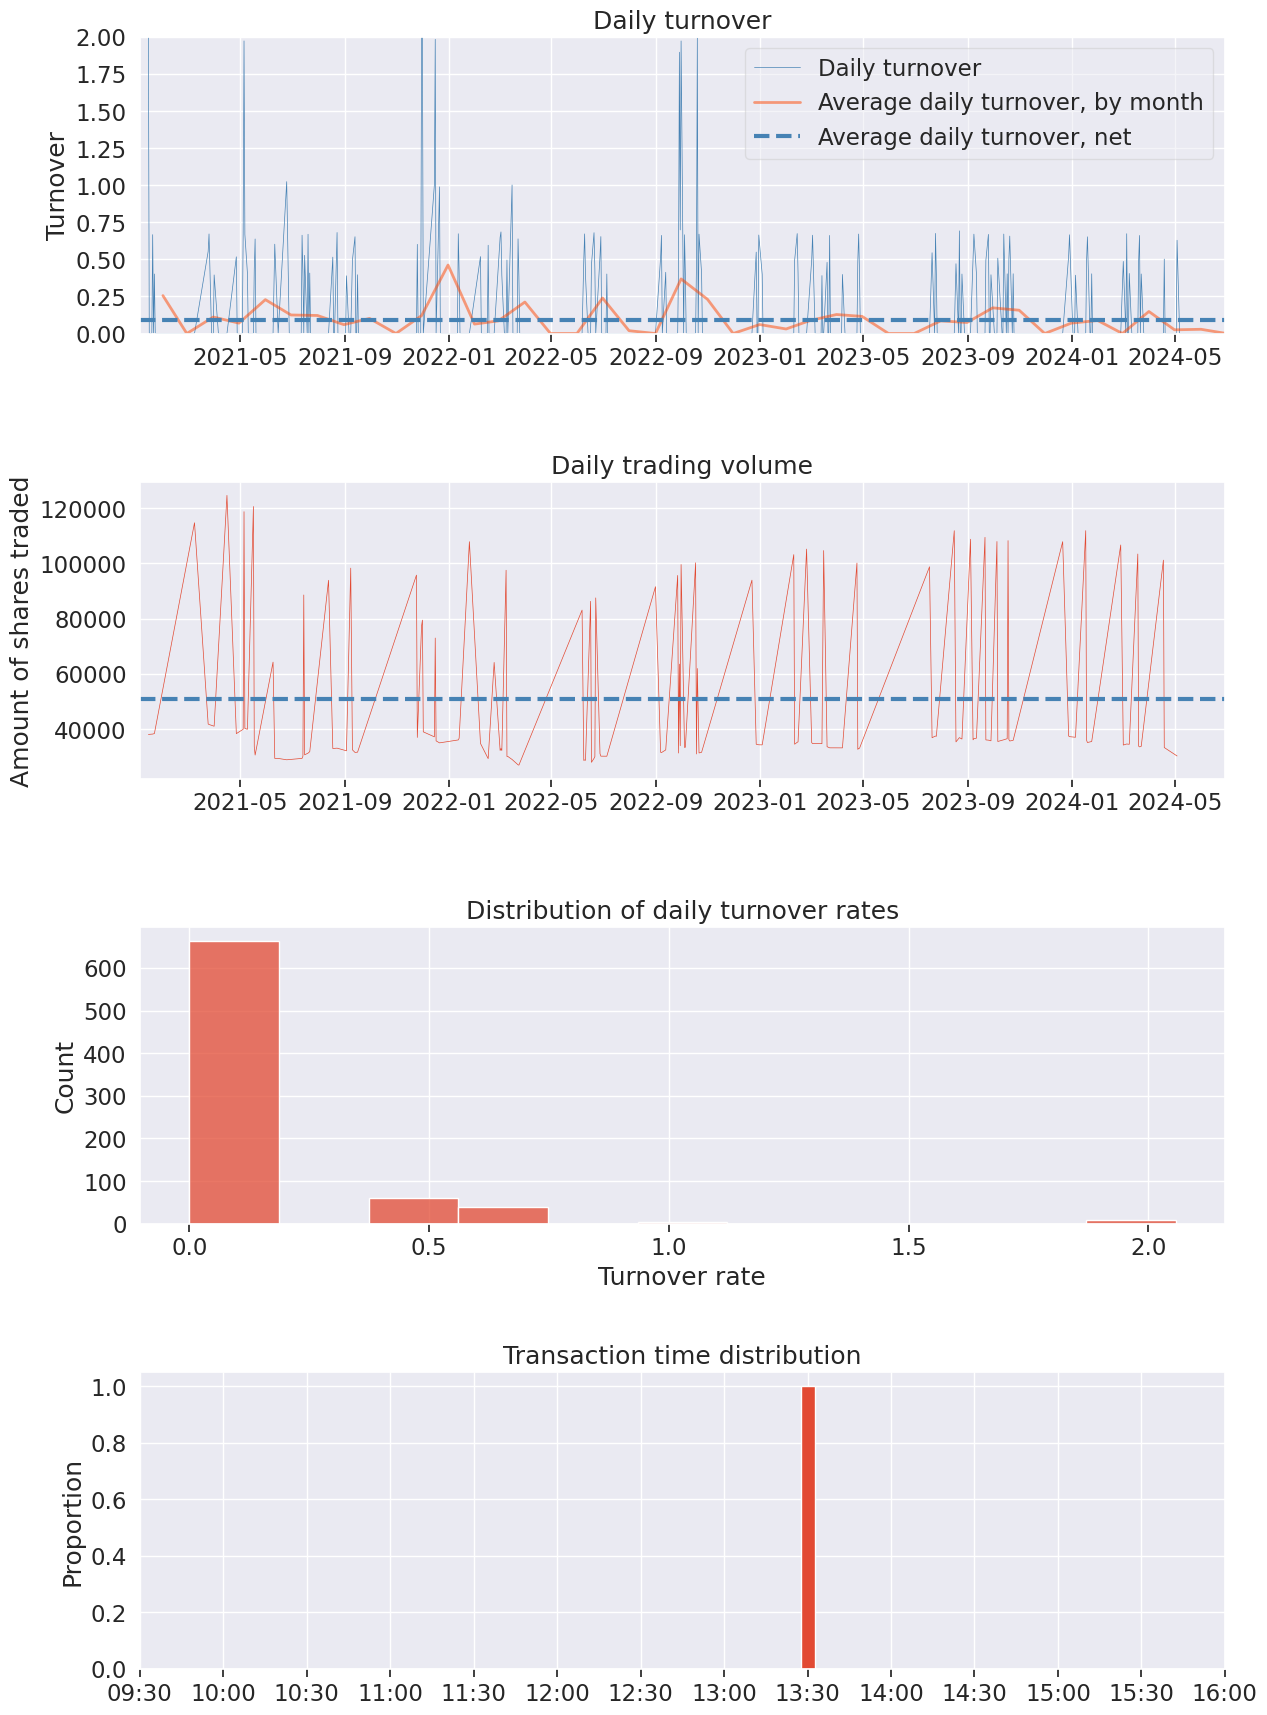

In [28]:
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

benchmark_rets = results['benchmark_return']
pf.tears.create_full_tear_sheet(returns=returns,
                                positions=positions,
                                transactions=transactions,
                                benchmark_rets=benchmark_rets
                                )